# 「プチ」勉強会 20230708
* 今回も機械学習。先週、実践課題を一通りやったので今回は応用の「レビューのスコアを予想しよう」に挑戦する。
* 自然言語処理がテーマで、前回の「スパムメールを分類しよう」を参考にやってみたところ、プラモデルを組み立てているような感じでイマイチ面白くない。<br>
* それは、自然言語処理が機械学習の大きなテーマのひとつで、専用ライブラリが揃っており、それを当て嵌めれば基本的な課題はとりあえずは簡単にクリアできてしまうから。<br>
* 一方で、数多くのレビューデータからEDAを駆使して特徴量を見出し、スコアを予想するプロセス自体はとても面白い。<br>
* だから、今回は、専用ライブラリを敢えて封印して、自分の持っている武器だけでやれるところまでやってみる試みとした<br>

## 今回取り組んでみたこと

1. ポイントは、データ数が12万近くあるので何も考えずに取り組んでいたら日が暮れても終わらないということ。<br>
如何に効率的にデータを処理し、より速く少ない計算量でデータを処理するか、コーディングの巧拙が試される。<br>

2. データはレビューの文章とスコアだけ。EDAは文章を読むことからだが、そもそもはっきりしていることがある。<br>
```
    つまり、今回のデータは、83%がスコア4と5で占められている。如何にネガティブな要素を抽出して、3以下を特定するかがポイントということ。
    数少ないネガティブ評価に含まれる語句を数えて評価し、特徴量に変換する必要がある。ポジティブは予想するまでもない。
    計算速度に関しては、なんといってもsetの積集合演算が爆速、次いで配列計算。如何にfor文を使わないかがポイント。
```

3. その他、可視化も多少工夫してみた。ネガティブワードとは何かが見えてくる。<br>
今回は、かなり面白くてためにもなった。

### それでは、let's get started!

## レビューのスコアを予測しよう

In [1]:
# 0-1
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor as RFG       # ランダムフォレスト
from sklearn.svm import SVR                                     # サポートベクタマシン

from sklearn.model_selection import train_test_split            # データ分割
from sklearn.metrics import mean_squared_error                  # MSE
import lightgbm as lgb                                          # Light GBM

from collections import defaultdict, Counter                    # collectionsライブラリ
from pprint import pprint
import warnings
warnings.simplefilter('ignore')

# 表示桁数の設定
%precision 3
pd.options.display.precision = 3

sns.set(style='white')
import japanize_matplotlib


In [2]:
# 0-2
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\review_score\\train.csv')
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\review_score\\test.csv') 

## データ概観

In [3]:
# 1-0
# 訓練データ
display(df.info())
display(df.head())
display(df.describe())
display(df.describe(include='object'))

# 提出用データ
display(df_test.info())
display(df_test.head())
display(df_test.describe())
display(df_test.describe(include='object'))

# 欠損値                     ： train   test
# review_text                :    2       0

# レビューテキストは文字通り文章なのでほとんどunique。
# 2つの欠損、あと108の重複はおそらくはエラー的なもの（#NAME?）と定型のコメントか繰り返しの投稿。
# あとはreview_socore別に単語の頻度調査を行って傾向を見ていく。
# 基本的に4と5が多い（平均4.229）
# 標準偏差0.97なのでそれ以下で予想したい（ベースラインはAll 4）

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118064 entries, 0 to 118063
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         118064 non-null  int64 
 1   review_text   118062 non-null  object
 2   review_score  118064 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.7+ MB


None

,index,review_text,review_score
0,80351,Sunday is relaxing day. But I want to explore ...,2
1,24757,My wife and I visited this restaurant on a qui...,1
2,114219,Came to Shang Palace for dinner and enjoyed th...,5
3,134782,The snacks are very good quality and the take ...,4
4,23792,We didn't know what to expect but were thoroug...,5


,index,review_score
count,118064.000,118064.000
mean,73831.045,4.229
std,42598.961,0.970
min,1.000,1.000
25%,36960.500,4.000
50%,73812.000,4.000
75%,110724.250,5.000
max,147580.000,5.000


,review_text
count,118062
unique,117954
top,#NAME?
freq,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29517 entries, 0 to 29516
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        29517 non-null  int64 
 1   review_text  29517 non-null  object
dtypes: int64(1), object(1)
memory usage: 461.3+ KB


None

,index,review_text
0,50923,Food is good but too much non veg dish creates...
1,48414,We love the buffet here. it is very famous fo...
2,17951,Great place for a chill evening on the weekday...
3,36227,A legendary restaurant of Delhi (and India) th...
4,30281,I had to walk for 2 hours and got lost trying ...


,index
count,29517.000
mean,73625.825
std,42620.025
min,0.000
25%,36669.000
50%,73690.000
75%,110578.000
max,147571.000


,review_text
count,29517
unique,29508
top,#NAME?
freq,5


## EDA（データ探索）

```Dataset.columns

review_score  : レビューのスコア
index         : レビューの固有 ID
review_text   : レビュー内容
```

In [4]:
# 欠損値処理

df = df.drop(index=[47171, 86303])
df.info()

# 欠損値は2つのみNaN表示なので削除するしかない

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118062 entries, 0 to 118063
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         118062 non-null  int64 
 1   review_text   118062 non-null  object
 2   review_score  118062 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
# 外れ値

# 明らかにネガティブな内容であるに関わらず高評価であったりその逆のものもあり、そういうものは、外れ値として除外したい
# しかし、量も多く、ひとつひとつ確認することは困難なのでここでは弄らない

In [6]:
# review_textのクリーニング

def clean_text(text):
    text = str(text).lower()                 # 小文字に変換
    text = re.sub(r'[^\s0-9a-z]', '', text)  # 数字と英数字以外を削除
    text = re.sub('\s+', ' ', text).strip()  # 余分なスペースの削除
    return text

df['clean_text'] = df['review_text'].apply(clean_text)
df_test['clean_text'] = df_test['review_text'].apply(clean_text)

display(df)
display(df_test)

# クリーニングの意味は、意味のある単語だけ残して特徴量の品質を高めることにある
# 最低限の処理として、小文字化と記号類の削除を行う（但し、あまり記号類が多い印象はない）
# nltk(自然言語キット)は自然言語処理の基本的なメソッドを提供していてSTOPWORDSも用意されているがここでは使用しない
# 必要に応じて自分で設定していけば精度を上げられる余地があると思う
# ちなみにSTOPWORDでもネガティブなニュアンスの文脈に頻出する傾向があれば特徴量とする意味がある

,index,review_text,review_score,clean_text
0,80351,Sunday is relaxing day. But I want to explore ...,2,sunday is relaxing day but i want to explore s...
1,24757,My wife and I visited this restaurant on a qui...,1,my wife and i visited this restaurant on a qui...
2,114219,Came to Shang Palace for dinner and enjoyed th...,5,came to shang palace for dinner and enjoyed th...
3,134782,The snacks are very good quality and the take ...,4,the snacks are very good quality and the take ...
4,23792,We didn't know what to expect but were thoroug...,5,we didnt know what to expect but were thorough...
...,...,...,...,...
118059,37678,I have been wanting to visit this cafe for qui...,4,i have been wanting to visit this cafe for qui...
118060,104347,We were four of us and had varied interest in ...,5,we were four of us and had varied interest in ...
118061,95950,We went for our anniversary celebration and si...,4,we went for our anniversary celebration and si...
118062,13824,had an amazing mouth lickering appetizer which...,5,had an amazing mouth lickering appetizer which...


,index,review_text,clean_text
0,50923,Food is good but too much non veg dish creates...,food is good but too much non veg dish creates...
1,48414,We love the buffet here. it is very famous fo...,we love the buffet here it is very famous for ...
2,17951,Great place for a chill evening on the weekday...,great place for a chill evening on the weekday...
3,36227,A legendary restaurant of Delhi (and India) th...,a legendary restaurant of delhi and india that...
4,30281,I had to walk for 2 hours and got lost trying ...,i had to walk for 2 hours and got lost trying ...
...,...,...,...
29512,111568,A nice place to enjoy meal with your family . ...,a nice place to enjoy meal with your family ex...
29513,134484,This place is a canteen for students and young...,this place is a canteen for students and young...
29514,130243,Good hotel good service. Saurabh at K3 was ver...,good hotel good service saurabh at k3 was very...
29515,6809,It has become a must do whenever I visit Delhi...,it has become a must do whenever i visit delhi...


### まずはtextの中身をよく見るのがEDAの基本で実は結構みたが、それをここでやると時間がないので省略。

In [7]:
# review_score == 1
df_01 = df[(df['review_score'] == 1)]
display(df_01)

scores = df['review_score'].value_counts()
print(scores)

# 1が最も評価が低く5が高い。
# 低評価の数は少なく、4と5が大部分なので、いかに低評価のものを見分けるかがポイント

,index,review_text,review_score,clean_text
1,24757,My wife and I visited this restaurant on a qui...,1,my wife and i visited this restaurant on a qui...
5,94698,Was pretty excited initially to find a place b...,1,was pretty excited initially to find a place b...
66,72890,Had a friend's bday party. Seems the cook was ...,1,had a friends bday party seems the cook was ha...
67,53542,In a strictly simplistic point of view piano m...,1,in a strictly simplistic point of view piano m...
83,52370,I am listing all things which went wrong durin...,1,i am listing all things which went wrong durin...
...,...,...,...,...
117909,51097,It was below average for all the food which I ...,1,it was below average for all the food which i ...
117935,8680,me and my friend go to this restuarant and eat...,1,me and my friend go to this restuarant and eat...
117938,42178,Our group of 12 people went for lunch. We were...,1,our group of 12 people went for lunch we were ...
117969,132708,We had to wait a good 20- 30 minutes before so...,1,we had to wait a good 20 30 minutes before som...


5    57872
4    40127
3    12859
2     3645
1     3559
Name: review_score, dtype: int64


In [8]:
# リーク防止のため最初から分割

df_train, df_val = train_test_split(df, test_size=0.2)


In [9]:
# 特徴量 text_len

df_train['text_len'] = df_train.apply(lambda x: len(str(x['review_text']).split()), axis=1)
df_val['text_len'] = df_val.apply(lambda x: len(str(x['review_text']).split()), axis=1)
df_test['text_len'] = df_test.apply(lambda x: len(str(x['review_text']).split()), axis=1)


display(df_train)

,index,review_text,review_score,clean_text,text_len
79030,129627,I am visiting this restaurant for last 10 year...,5,i am visiting this restaurant for last 10 year...,50
88446,124557,Tldr: awesome multi cuisine restaurant/pub for...,5,tldr awesome multi cuisine restaurantpub for f...,240
26303,39721,It was the best food in Delhi and probably Ind...,5,it was the best food in delhi and probably ind...,55
99638,146788,"Great ambience, interesting cocktails, super f...",5,great ambience interesting cocktails super foo...,28
61828,138581,Service needs to be improved although food was...,3,service needs to be improved although food was...,22
...,...,...,...,...,...
64570,137247,I have been to this place numerous times and i...,4,i have been to this place numerous times and i...,74
36568,112250,It's probably not fair to judge a restaurant a...,3,its probably not fair to judge a restaurant af...,93
49060,146180,They provided a professional service during br...,5,they provided a professional service during br...,27
102427,70910,Attended a birthday party there. Location is g...,3,attended a birthday party there location is go...,65


In [10]:
# 特徴量 diff_len

df_train['diff_len'] = df_train['text_len'] - df_train.apply(lambda x: len(str(x['clean_text']).split()), axis=1)
df_val['diff_len'] = df_val['text_len'] - df_val.apply(lambda x: len(str(x['clean_text']).split()), axis=1)
df_test['diff_len'] = df_test['text_len'] - df_test.apply(lambda x: len(str(x['clean_text']).split()), axis=1)

display(df_train)

# 全般に特殊文字や記号が少なく、また、STOPWORDSを使っていないのでdiff_lenは少ししかない。
# STOPWORDSを使うとdiff_lenでも低スコアの比率が高いことがわかる

,index,review_text,review_score,clean_text,text_len,diff_len
79030,129627,I am visiting this restaurant for last 10 year...,5,i am visiting this restaurant for last 10 year...,50,0
88446,124557,Tldr: awesome multi cuisine restaurant/pub for...,5,tldr awesome multi cuisine restaurantpub for f...,240,3
26303,39721,It was the best food in Delhi and probably Ind...,5,it was the best food in delhi and probably ind...,55,0
99638,146788,"Great ambience, interesting cocktails, super f...",5,great ambience interesting cocktails super foo...,28,1
61828,138581,Service needs to be improved although food was...,3,service needs to be improved although food was...,22,1
...,...,...,...,...,...,...
64570,137247,I have been to this place numerous times and i...,4,i have been to this place numerous times and i...,74,0
36568,112250,It's probably not fair to judge a restaurant a...,3,its probably not fair to judge a restaurant af...,93,0
49060,146180,They provided a professional service during br...,5,they provided a professional service during br...,27,0
102427,70910,Attended a birthday party there. Location is g...,3,attended a birthday party there location is go...,65,0


<Axes: xlabel='diff_len', ylabel='review_score'>

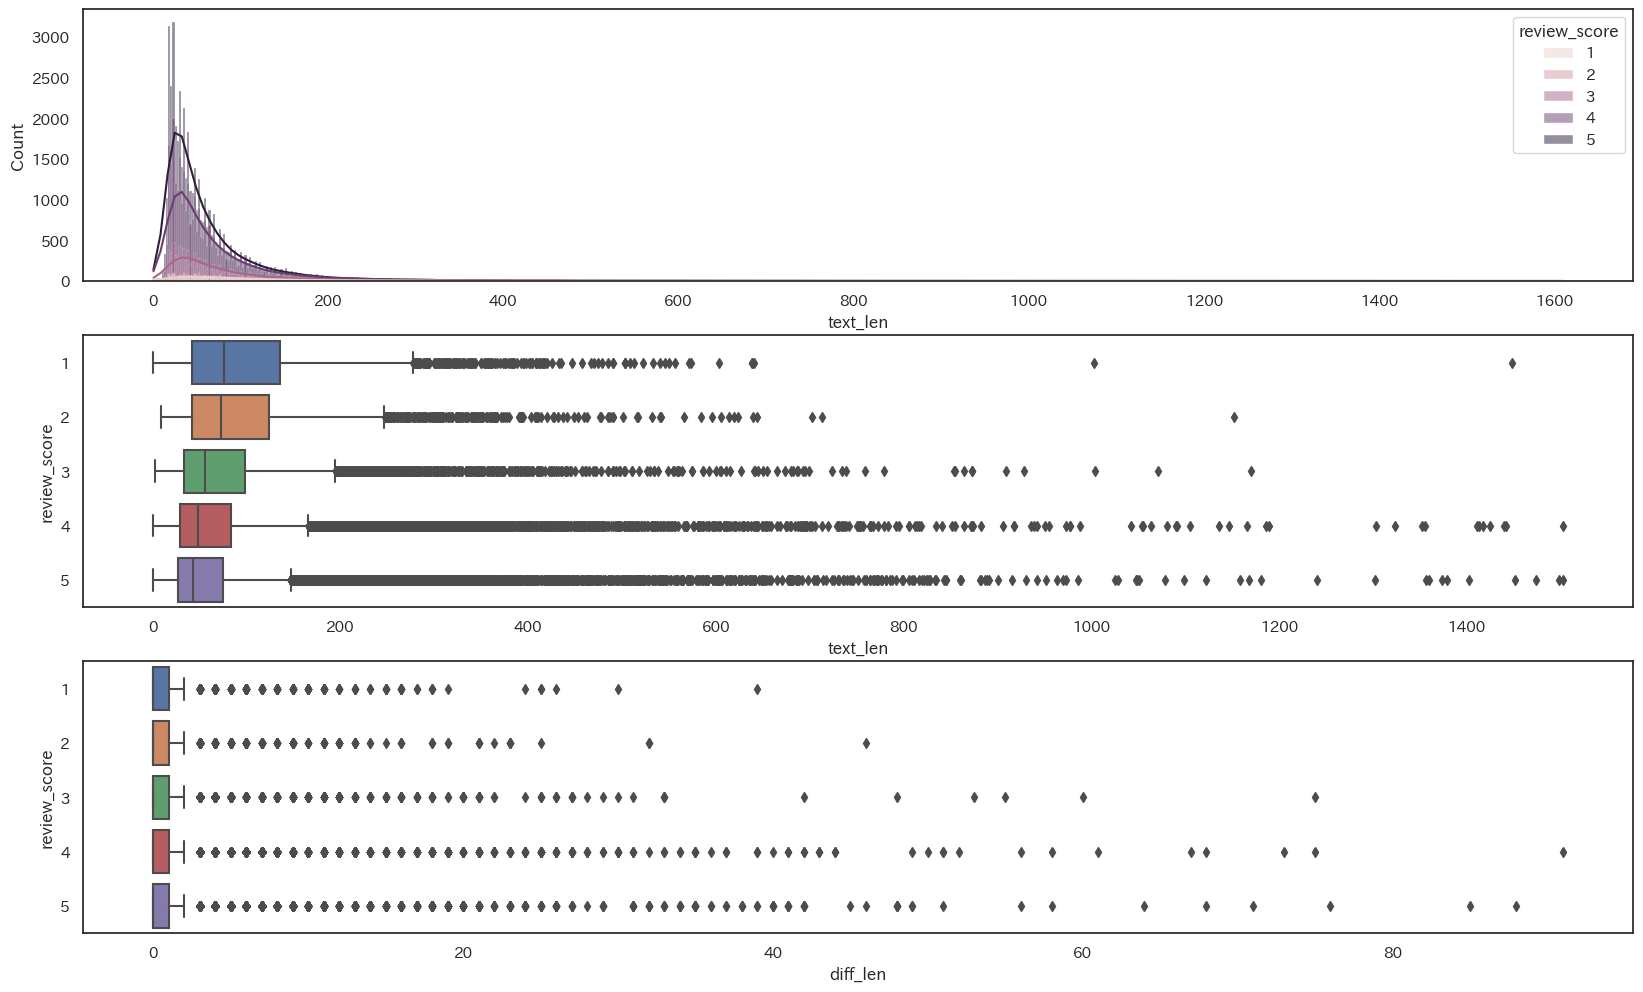

In [11]:
# 可視化

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
sns.histplot(data=df_train, x='text_len', kde=True, hue='review_score', ax=ax1)
df_ = df_train[df_train['text_len']<1000]
df_ = df_train[df_train['diff_len']<100]
sns.boxplot(data=df_, y='review_score', x='text_len', orient='h', ax=ax2)
sns.boxplot(data=df_, y='review_score', x='diff_len', orient='h', ax=ax3)

In [12]:
# df_fw (df_trainから頻出wordのスコア別頻度表を作成)

df_fw = pd.DataFrame()
scores = set(df_train['review_score'])

for score in scores:
    data = df_train[df_train['review_score'] == score]
    text = ' '.join([i for i in data['clean_text']])
    text1 = Counter(text.split()).most_common()
    for j in text1:
        df_fw.loc[j[0], 'score' + str(score)] = j[1] * 100000 / len(text)
    print(f'score{score}: {len(text)} words ')
df_fw = df_fw.fillna(0)

# ここは今回の肝の部分。全量から抽出しているので少し時間が掛かるがギリギリ許容範囲。
# 頻出wordをスコア別の頻度に変換して抽出しデータフレームにする。
# word数が百万～10百万以上あるので数字が小さくなりすぎないよう分子に10万を掛けている。

score1: 1579977 words 
score2: 1539762 words 
score3: 4409974 words 
score4: 12819891 words 
score5: 16858300 words 


In [13]:
# df_fwのsocore1での出現頻度が1/20000以上, 3文字以上のものに絞り込む

df_fw['bins'] = pd.cut(df_fw['score1'], bins=40000, labels=[i for i in range(1, 40001)], duplicates='drop')
df_fw = df_fw[(df_fw['bins']>1) & (df_fw.index.str.len() >= 3)]
df_fw = df_fw.drop(columns='bins')
df_fw

# このあとの特徴量への変換を効率的に行うため、計算時間を勘案しつつデータを削減する。

,score1,score2,score3,score4,score5
the,942.419,1049.123,1035.267,972.403,933.166
and,577.287,550.150,567.668,667.634,733.888
was,387.727,438.639,396.828,304.948,302.747
for,233.041,241.076,240.296,233.426,221.048
not,196.079,213.215,178.550,87.887,57.799
...,...,...,...,...,...
surcharge,0.063,0.000,0.000,0.008,0.000
fanta,0.063,0.000,0.000,0.047,0.036
interiour,0.063,0.000,0.000,0.008,0.006
dec16,0.063,0.000,0.000,0.000,0.000


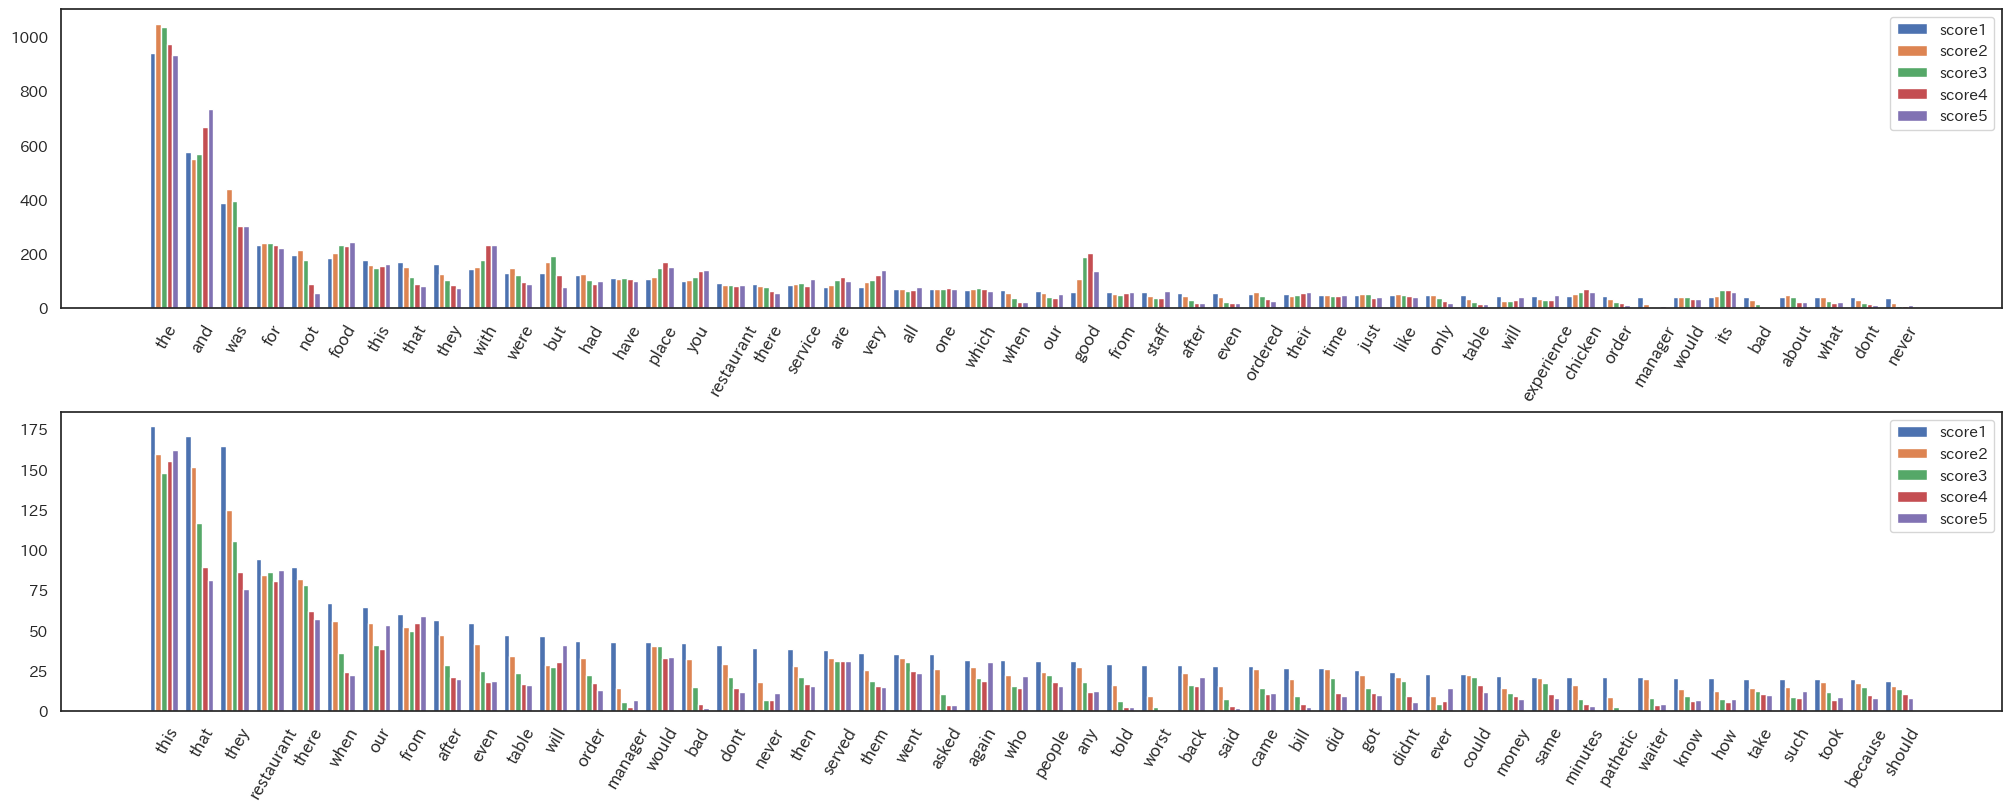

In [14]:
# 可視化
app = 50

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), layout='constrained')
x = np.arange(len(df_fw.index[:app]))
width = 0.8 / len(df_fw.columns)
for i, c in enumerate(df_fw.columns):
    pos = -0.4 + width * i
    ax1.bar(x + pos, df_fw.loc[df_fw.index[:app], c].T,
           width=width, label=c)
ax1.set_xticks(x)
ax1.set_xticklabels(df_fw.index[:app])
ax1.tick_params(axis='x', rotation=60, labelsize=12)
ax1.legend()

df_fw1 = df_fw[df_fw.T.idxmax() == 'score1']
x = np.arange(len(df_fw1.index[:app]))
width = 0.8 / len(df_fw1.columns)
for i, c in enumerate(df_fw1.columns):
    pos = -0.4 + width * i
    ax2.bar(x + pos, df_fw1.loc[df_fw1.index[:app], c].T,
           width=width, label=c)
ax2.set_xticks(x)
ax2.set_xticklabels(df_fw1.index[:app])
ax2.tick_params(axis='x', rotation=60, labelsize=12)
ax2.legend()

# 出現頻度順に並べてみると低評価で出現率が突出する明らかなネガティブワードがあることが分かる
# 必ずしもそのword自体に否定的な意味はなくてもwordの対象に文句があるときに出てきやすい語句と推測できる ⇒ 「レビュースコアに影響する因子」
# that, they, when, after, even, only, table, bad, order, dont, manager, never, asked, worst, told, said, bill, got, money, minutes, waiter, patheticなど
# 内容を読めば、料理の味に関するものもみられるが、数的にはスタッフやマネージャーの接客態度などに関するクレームが圧倒的に多い。

In [15]:
# (df_fw) ng_ratio

df_fw['ng_ratio'] = df_fw.apply(lambda x:
    ((x['score1'] * 3 + x['score2'] * 2 + x['score3']) / 6
     / ((x['score4'] + x['score5']) / 2)), axis=1)

# ネガティブレシオは、ネガティブな要素のある3以下とポジティブな4以上の比率を算出したもの。
# 3以下については、低スコアほど影響が出るよう重み付けを行っている。

In [16]:
# (df_fw) pred_score

df_fw['pred_score'] = df_fw.apply(lambda x:
    (x['score1'] * 0.5 + x['score2'] * 1.5 + x['score3'] * 3 + x['score4'] * 4.5 + x['score5'] * 5.5)
    / (x['score1'] + x['score2'] + x['score3'] + x['score4'] + x['score5']), axis=1)
df_fw

# 特徴量として一列、簡易予想スコアを作成する準備。

,score1,score2,score3,score4,score5,ng_ratio,pred_score
the,942.419,1049.123,1035.267,972.403,933.166,1.043,2.972
and,577.287,550.150,567.668,667.634,733.888,0.809,3.183
was,387.727,438.639,396.828,304.948,302.747,1.337,2.774
for,233.041,241.076,240.296,233.426,221.048,1.043,2.965
not,196.079,213.215,178.550,87.887,57.799,2.730,2.272
...,...,...,...,...,...,...,...
surcharge,0.063,0.000,0.000,0.008,0.000,8.114,0.939
fanta,0.063,0.000,0.000,0.047,0.036,0.768,3.007
interiour,0.063,0.000,0.000,0.008,0.006,4.609,1.290
dec16,0.063,0.000,0.000,0.000,0.000,inf,0.500


In [17]:
# 特徴量 pred_score

df_train['pred_score'] = df_train.apply(lambda x: df_fw.loc[list(set(x['clean_text'].split()) & set(df_fw.index[:5000])), 'pred_score'].mean(), axis=1)
df_val['pred_score'] = df_val.apply(lambda x: df_fw.loc[list(set(x['clean_text'].split()) & set(df_fw.index[:5000])), 'pred_score'].mean(), axis=1)
df_test['pred_score'] = df_test.apply(lambda x: df_fw.loc[list(set(x['clean_text'].split()) & set(df_fw.index[:5000])), 'pred_score'].mean(), axis=1)

# 各行のclean_textに含まれるwordのうち、df_fwから抽出した5000語に該当するものの平均をpred_scoreとしてプロットする。
# 配列演算とsetの積集合演算を利用することで高速化を実現。

In [18]:
# ng_word: ng_wordのng_raio別配列（set）

ng_word = defaultdict(set)
for ratio in range(2, 21):
    ng_word[ratio] = set(df_fw[df_fw['ng_ratio'] >= ratio].index)

pprint(ng_word[20], compact=True)
print(len(ng_word[20]))

# 特徴量 ng_nの準備。ng_ratioの水準別にwordのsetを分別してdefautdictに格納している。

{'0026', '0100hrs', '01022018', '0130', '0142', '0143', '017729it', '0212015',
 '0302', '03072014', '0400', '055', '0600', '070714', '0800hrs', '0taste',
 '0waiters', '1000r', '100200', '10032019', '100usd', '1010for', '1010pm',
 '1025', '10301045', '1030pmwe', '1040', '1047', '10600not', '10717', '10830pm',
 '10best', '10feet', '10ish', '10minutes', '10oct2018', '10usd', '1100am',
 '110th', '11118', '1115pm', '1119for', '113498', '1140', '120b', '1210',
 '12112016', '1216', '122000', '12618', '1270', '129', '130pmwe', '1340',
 '13689', '13800', '13min', '141', '145pm', '1500inr', '15072016', '150rp',
 '1510', '15minute', '15over5', '15times', '16052020', '160rsbut', '16thof',
 '1729', '17k', '180what', '1866', '190then', '1932015', '197rs', '199094',
 '19year', '1juices', '1laccha', '1stthis', '1yrs', '2000rs', '20072016',
 '200compare', '200gms', '201220', '2012when', '20198', '2021', '2035', '20inr',
 '20k', '20minute', '20moreover', '21082013', '21102017', '213', '2150',
 '215153',

In [19]:
# 特徴量 ng_n: 重み付き頻度別ng_word出現数

for i in range(2, 21, 2):
    df_train['ng' + str(i)] = df_train.apply(lambda x: len(set(x['clean_text'].split()) & ng_word[i]), axis=1)
    df_val['ng' + str(i)] = df_val.apply(lambda x: len(set(x['clean_text'].split()) & ng_word[i]), axis=1)
    df_test['ng' + str(i)] = df_val.apply(lambda x: len(set(x['clean_text'].split()) & ng_word[i]), axis=1)

df_train = df_train.fillna(0)
df_val = df_val.fillna(0)
df_test = df_test.fillna(0)

display(df_train)
display(df_train[df_train['review_score'] == 1])

# 何度か試行した結果、ng_ratio20くらいまでが有効と分かったので1つ置きに作成。
# ここもsetの積集合演算を使用して高速計算。

,index,review_text,review_score,clean_text,text_len,diff_len,pred_score,ng2,ng4,ng6,ng8,ng10,ng12,ng14,ng16,ng18,ng20
79030,129627,I am visiting this restaurant for last 10 year...,5,i am visiting this restaurant for last 10 year...,50,0,3.113,0,0,0,0,0,0,0,0,0,0
88446,124557,Tldr: awesome multi cuisine restaurant/pub for...,5,tldr awesome multi cuisine restaurantpub for f...,240,3,3.111,15,3,2,2,0,0,0,0,0,0
26303,39721,It was the best food in Delhi and probably Ind...,5,it was the best food in delhi and probably ind...,55,0,3.183,3,0,0,0,0,0,0,0,0,0
99638,146788,"Great ambience, interesting cocktails, super f...",5,great ambience interesting cocktails super foo...,28,1,3.477,0,0,0,0,0,0,0,0,0,0
61828,138581,Service needs to be improved although food was...,3,service needs to be improved although food was...,22,1,2.989,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64570,137247,I have been to this place numerous times and i...,4,i have been to this place numerous times and i...,74,0,3.151,3,1,1,0,0,0,0,0,0,0
36568,112250,It's probably not fair to judge a restaurant a...,3,its probably not fair to judge a restaurant af...,93,0,3.049,5,1,0,0,0,0,0,0,0,0
49060,146180,They provided a professional service during br...,5,they provided a professional service during br...,27,0,3.101,2,0,0,0,0,0,0,0,0,0
102427,70910,Attended a birthday party there. Location is g...,3,attended a birthday party there location is go...,65,0,2.934,7,1,0,0,0,0,0,0,0,0


,index,review_text,review_score,clean_text,text_len,diff_len,pred_score,ng2,ng4,ng6,ng8,ng10,ng12,ng14,ng16,ng18,ng20
39838,23325,Arrived back in New Delhi tonight and decided ...,1,arrived back in new delhi tonight and decided ...,109,0,2.624,32,11,8,7,5,5,5,5,5,4
67,53542,In a strictly simplistic point of view piano m...,1,in a strictly simplistic point of view piano m...,189,0,2.781,26,10,3,3,3,3,3,3,3,3
6298,96008,Though the location is in heart of delhi i.e. ...,1,though the location is in heart of delhi ie co...,102,1,2.730,23,9,8,5,4,3,3,2,2,2
102675,32669,The place is disgusting. Smells like vomit. On...,1,the place is disgusting smells like vomit once...,64,0,2.704,13,5,4,3,3,3,3,3,3,3
55841,53194,What I mean is when you place order for your d...,1,what i mean is when you place order for your d...,78,1,2.525,19,13,10,10,10,10,8,7,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83477,132505,Bakeries there days are mushrooming like anyth...,1,bakeries there days are mushrooming like anyth...,100,0,2.777,18,6,4,2,2,1,1,1,1,1
13424,25670,Majority of the guests here are tourists and f...,1,majority of the guests here are tourists and f...,57,0,2.728,8,3,3,2,2,2,2,2,2,1
13829,65060,"Rude staff, orchestra type music and mediocre ...",1,rude staff orchestra type music and mediocre e...,26,0,2.579,5,4,4,4,3,3,3,3,2,2
33547,82991,The surcharge and service fee make the restaur...,1,the surcharge and service fee make the restaur...,35,0,2.713,9,2,1,1,0,0,0,0,0,0


In [20]:
# 特徴量 words(df_fwの各wordの高頻度部分のみpred_scoreをプロット)

new_columns  = [i for i in df_fw.index][:5000] # 5000word

df_train[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)
df_val[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df_val.index)
df_test[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df_test.index)

for col in df_train.columns[17:]:
    mask = df_train['review_text'].str.contains(col)
    df_train.loc[mask, col] = df_fw.at[col, 'ng_ratio']
df_train = df_train.fillna(0)

for col in df_val.columns[17:]:
    mask = df_val['clean_text'].str.contains(col)
    df_val.loc[mask, col] = df_fw.at[col, 'ng_ratio']
df_val = df_val.fillna(0)

for col in df_test.columns[17:]:
    mask = df_test['clean_text'].str.contains(col)
    df_test.loc[mask, col] = df_fw.at[col, 'ng_ratio']
df_test = df_test.fillna(0)

# 最後に個別のwordのng_ratioを特徴量として使用。高頻度5000wordで試行。
# 各列への適用にfor文を使用しているので多少時間を要するが、配列計算を併用することでこのくらいで済んでいる。

In [21]:
display(df_train.iloc[:,:30])
display(df_train.loc[df_train['review_score']==1, 'review_score':'you'])

,index,review_text,review_score,clean_text,text_len,diff_len,pred_score,ng2,ng4,ng6,...,for,not,food,this,that,they,with,were,but,had
79030,129627,I am visiting this restaurant for last 10 year...,5,i am visiting this restaurant for last 10 year...,50,0,3.113,0,0,0,...,1.043,0.00,0.84,1.049,0.000,0.0,0.000,0.000,0.000,0.000
88446,124557,Tldr: awesome multi cuisine restaurant/pub for...,5,tldr awesome multi cuisine restaurantpub for f...,240,3,3.111,15,3,2,...,1.043,2.73,0.84,1.049,1.814,0.0,0.654,1.446,0.000,1.271
26303,39721,It was the best food in Delhi and probably Ind...,5,it was the best food in delhi and probably ind...,55,0,3.183,3,0,0,...,0.000,0.00,0.84,0.000,0.000,0.0,0.000,1.446,0.000,1.271
99638,146788,"Great ambience, interesting cocktails, super f...",5,great ambience interesting cocktails super foo...,28,1,3.477,0,0,0,...,1.043,0.00,0.84,1.049,0.000,0.0,0.000,0.000,0.000,0.000
61828,138581,Service needs to be improved although food was...,3,service needs to be improved although food was...,22,1,2.989,0,0,0,...,0.000,0.00,0.84,0.000,0.000,0.0,0.000,0.000,1.526,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64570,137247,I have been to this place numerous times and i...,4,i have been to this place numerous times and i...,74,0,3.151,3,1,1,...,0.000,2.73,0.00,1.049,0.000,0.0,0.654,0.000,0.000,0.000
36568,112250,It's probably not fair to judge a restaurant a...,3,its probably not fair to judge a restaurant af...,93,0,3.049,5,1,0,...,0.000,2.73,0.00,1.049,0.000,0.0,0.000,1.446,1.526,0.000
49060,146180,They provided a professional service during br...,5,they provided a professional service during br...,27,0,3.101,2,0,0,...,0.000,0.00,0.00,0.000,0.000,0.0,0.000,0.000,0.000,0.000
102427,70910,Attended a birthday party there. Location is g...,3,attended a birthday party there location is go...,65,0,2.934,7,1,0,...,0.000,2.73,0.84,0.000,1.814,0.0,0.000,0.000,1.526,0.000


,review_score,clean_text,text_len,diff_len,pred_score,ng2,ng4,ng6,ng8,ng10,...,this,that,they,with,were,but,had,have,place,you
39838,1,arrived back in new delhi tonight and decided ...,109,0,2.624,32,11,8,7,5,...,0.000,0.000,0.000,0.000,0.0,1.526,0.000,0.000,0.000,0.00
67,1,in a strictly simplistic point of view piano m...,189,0,2.781,26,10,3,3,3,...,1.049,1.814,1.745,0.654,0.0,0.000,1.271,1.052,0.724,0.75
6298,1,though the location is in heart of delhi ie co...,102,1,2.730,23,9,8,5,4,...,0.000,1.814,0.000,0.000,0.0,0.000,0.000,0.000,0.724,0.75
102675,1,the place is disgusting smells like vomit once...,64,0,2.704,13,5,4,3,3,...,0.000,0.000,0.000,0.654,0.0,0.000,0.000,0.000,0.724,0.75
55841,1,what i mean is when you place order for your d...,78,1,2.525,19,13,10,10,10,...,0.000,1.814,1.745,0.654,0.0,0.000,0.000,0.000,0.724,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83477,1,bakeries there days are mushrooming like anyth...,100,0,2.777,18,6,4,2,2,...,1.049,0.000,1.745,0.654,0.0,1.526,1.271,1.052,0.724,0.00
13424,1,majority of the guests here are tourists and f...,57,0,2.728,8,3,3,2,2,...,0.000,0.000,1.745,0.000,0.0,1.526,1.271,0.000,0.000,0.00
13829,1,rude staff orchestra type music and mediocre e...,26,0,2.579,5,4,4,4,3,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.00
33547,1,the surcharge and service fee make the restaur...,35,0,2.713,9,2,1,1,0,...,0.000,0.000,0.000,0.000,0.0,0.000,1.271,0.000,0.000,0.00


In [22]:
# 特徴量削除

df_train = df_train.drop(columns=['index','review_text', 'clean_text'])
df_val = df_val.drop(columns=['index','review_text', 'clean_text'])
df_test = df_test.drop(columns=['index','review_text', 'clean_text'])

# indexと用済みのtext列を削除
# 12万行あると消すのにも時間がかかる

## 機械学習モデルの適用

In [23]:
X_train = df_train.drop(columns='review_score')
y_train = df_train['review_score']
X_val = df_val.drop(columns='review_score')
y_test = df_val['review_score']

In [24]:
# Light GBM

params = {"objective": "regression","metrics": "rmse"}
trains = lgb.Dataset(X_train, y_train)
valids = lgb.Dataset(X_val, y_test)
lgb_model = lgb.train(params, trains, valid_sets=valids,
                      num_boost_round=1000, early_stopping_rounds=100)

lgb_pred = lgb_model.predict(df_test)

# light GBMがとにかく速いのでここはlight GBMにお任せ。
# 2分かからないなんて凄い。
# 特徴量をブラッシュアップする毎に数値の改善とともに下がるのも早くなっている。

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.510727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9589
[LightGBM] [Info] Number of data points in the train set: 94449, number of used features: 4363
[LightGBM] [Info] Start training from score 4.231426
[1]	valid_0's rmse: 0.927928
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.889054
[3]	valid_0's rmse: 0.85596
[4]	valid_0's rmse: 0.827595
[5]	valid_0's rmse: 0.803455
[6]	valid_0's rmse: 0.782745
[7]	valid_0's rmse: 0.765534
[8]	valid_0's rmse: 0.750651
[9]	valid_0's rmse: 0.738354
[10]	valid_0's rmse: 0.727517
[11]	valid_0's rmse: 0.718309
[12]	valid_0's rmse: 0.710287
[13]	valid_0's rmse: 0.703698
[14]	valid_0's rmse: 0.698042
[15]	valid_0's rmse: 0.69316
[16]	valid_0's rmse: 0.688546
[17]	valid_0's rmse: 0.684886
[18]	valid_0's rmse: 0.68143

In [25]:
# このほかに重回帰も合せてスタッキングをやろうと思ったが、計算に時間が掛かりすぎるので一旦中止

# ランダムフォレスト

#RFG_model = RFG()
#RFG_model.fit(X_train, y_train)
#RFG_pred_train = RFG_model.predict(X_train)
#RFG_pred_val = RFG_model.predict(X_val)

#np.sqrt(mean_squared_error(RFG_pred_val, y_test))

In [26]:
# サポートベクタマシン
#SVR_model = SVR()
#SVR_model.fit(X_train, y_train)
#SVR_pred_train = SVR_model.predict(X_train)
#SVR_pred_val = SVR_model.predict(X_val)

#np.sqrt(mean_squared_error(SVR_pred_val, y_test))

In [27]:
# meta_Light GBM(スタッキング)

#stacked_features_train = np.column_stack((RFG_pred_train, SVR_pred_train))
#stacked_features_val = np.column_stack((RFG_pred_val, SVR_pred_val))

#params = {"objective": "regression","metrics": "rmse"}
#trains = lgb.Dataset(stacked_features_train, y_train)
#valids = lgb.Dataset(stacked_features_val, y_test)
#meta_lgb_model = lgb.train(params, trains, valid_sets=valids,
#                      num_boost_round=1000, early_stopping_rounds=100)

#meta_lgb_pred = meta_lgb_model.predict(df_test)

## 提出用データ

In [28]:
# 7-2 提出用データファイルのセッティング
df_submit = pd.read_csv('C:\\Users\\yuich\\KC_data\\review_score\\sample_submission.csv') 
df_submit['y'] = lgb_pred
df_submit.set_index('index', inplace=True)
df_submit.to_csv('submission.csv')

# なお、predictionの数値にはは少数もついているので提出時は整数に要変換

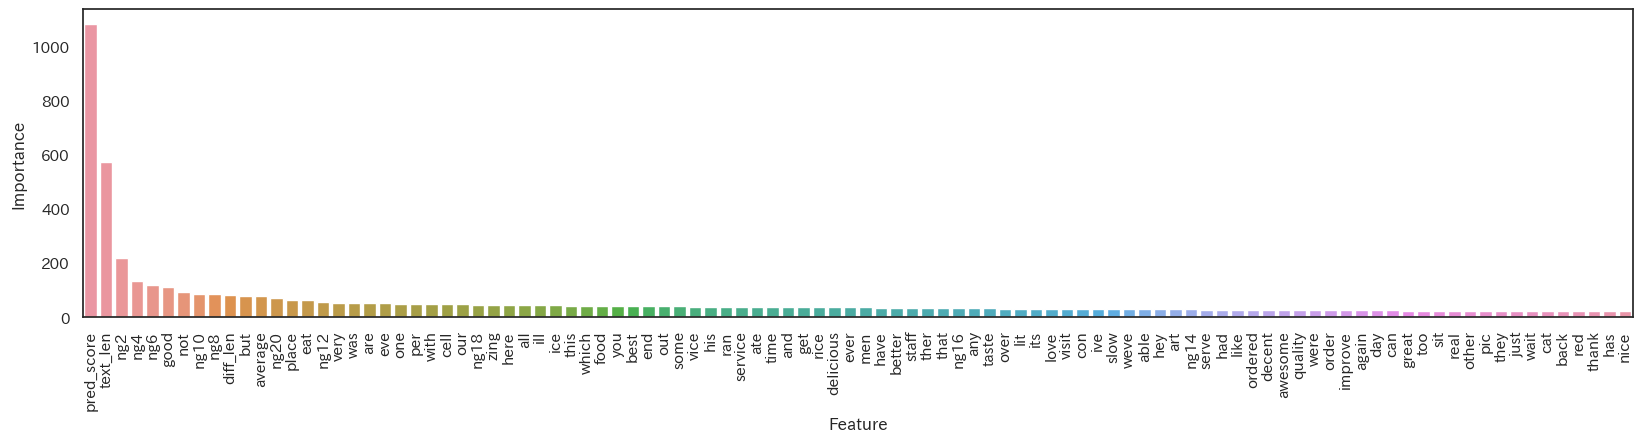

In [29]:
# 特徴量の重要度の可視化

importance = lgb_model.feature_importance()
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
importance_df = importance_df.sort_values('Importance', ascending=False)
fig, ax = plt.subplots(figsize=(20, 4))
sns.barplot(data=importance_df.iloc[:100, :], x='Feature', y='Importance', ax=ax)
ax.tick_params(axis='x', rotation=90)

# 「木系」のfeature_importanceは不純度を大きく下げる特徴量の数値が高い
# text_lenなど頻度の高いものが上位に来やすい。

In [30]:
a = b


NameError: name 'b' is not defined

## 専用ライブラリを使用した予測手順

```
「スパムメールを分類しよう」の動画で示されたscikit-learnライブラリを用いたBoW（Bag of Words：単語の出現頻度情報を含むベクトル化）
このほか、前処理にnltkも使用した。
```

In [ ]:
# BoWのデータフレーム作成

# データ抽出
X = df['clean_text']
y = df['review_score']
testX = df_test['clean_text']

# CountVectorizerによる出現回数のデータを作成
vect = CountVectorizer(min_df=50)
X_dtm = vect.fit_transform(X)
X_dtm_test = vect.transform(testX)

# TFitdf変換
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_dtm)
X_dtm = tfidf_transformer.transform(X_dtm)
X_dtm_test = tfidf_transformer.transform(X_dtm_test)

# データフレームを作成
X_dtm_df = pd.DataFrame(X_dtm.toarray(), columns=vect.get_feature_names_out())
X_dtm_df['text_len'] = df['text_len']  # テキストの長さを特徴量に追加
X_dtm_df['diff_len'] = df['diff_len']  # diffの長さを特徴量に追加

X_dtm_df_test = pd.DataFrame(X_dtm_test.toarray(), columns=vect.get_feature_names_out())
X_dtm_df_test['text_len'] = df_test['text_len']  # テキストの長さを特徴量に追加
X_dtm_df_test['diff_len'] = df_test['diff_len']  # diffの長さを特徴量に追加

display(X_dtm_df)
display(X_dtm_df_test)

# 全部デフォルトで変換すると以下のエラーで止まるので、CountVectorizerの引数min_dfで出現頻度50回未満のものを除外。
# パソコンのメモリ16GBしかないのに66GBとか無理・・・。
# MemoryError: Unable to allocate 66.6 GiB for an array with shape (118062, 75725) and data type int64


In [ ]:
# バリデーションデータの分割

X_train, X_val, y_train, y_test = train_test_split(X_dtm_df, y, test_size=0.2)

In [ ]:
# Light GBM
import lightgbm as lgb

params = {"objective": "regression","metrics": "rmse"}
trains = lgb.Dataset(X_train, y_train)
valids = lgb.Dataset(X_val, y_test)
lgb_model = lgb.train(params, trains, valid_sets=valids,
                      num_boost_round=1000, early_stopping_rounds=100)
lgb_pred = lgb_model.predict(X_val)

## 提出用データ

In [ ]:
# Light GBM

params = {"objective": "regression","metrics": "rmse"}
trains = lgb.Dataset(X_dtm_df, y)
lgb_model = lgb.train(params, trains, num_boost_round=1000)
lgb_pred = lgb_model.predict(X_dtm_df_test)

In [ ]:
# 7-2 提出用データファイルのセッティング
df_submit = pd.read_csv('C:\\Users\\yuich\\KC_data\\review_score\\sample_submission.csv') 
df_submit['y'] = lgb_pred
df_submit.set_index('index', inplace=True)
df_submit.to_csv('submission.csv')